# Importation des bibliothèques et des plates-formes

In [178]:
import string 
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow as tf
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

#  Lecture des données

In [183]:
# READ THE CSV FILE
movie_reviews = pd.read_csv("./IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [184]:
#exemple des données
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [185]:
# vérifier les valeurs de sentiment
# 1 est un sentiment positif et 0 est un sentiment négatif
movie_reviews['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [186]:
#montrant 3 avis
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<AxesSubplot:xlabel='sentiment', ylabel='count'>

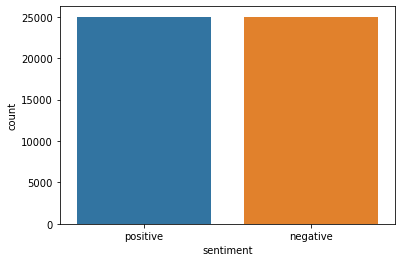

In [187]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

# Prétraitement des données

In [188]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [189]:
def preprocess_text(sen):
    # Supprimer les balises html
    sentence = remove_tags(sen)

    # Supprimer les signes de ponctuation et les chiffres
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Suppression d'un seul caractère
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Suppression de plusieurs espaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [190]:
#nettoyage des données

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [191]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [192]:
#Exemple de 3 revues avant le prétraitement
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [193]:
#Exemple de 3 revues après le prétraitement
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [194]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

# Fractionnement et Tokenisation des données

In [195]:
#Fractionnement du entrainement de données:70%    validation:10%    test:20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,test_size=0.20, random_state=101, shuffle=False)

In [196]:
#extraire les jetons du texte le nombre de jetons est de 5000
tokenizer = Tokenizer(num_words=5000)

#création du dictionnaire
tokenizer.fit_on_texts(X_train)

# convertir le texte en une séquence numérique
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [197]:
# Ajout de 1 à cause de l'index 0 réservé pour l'attribut UNKNOWN
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

#s’assurer que toutes les séquences d’une liste ont la même longueur.
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [198]:
# importer le dictionnaire de mots 'glove.6B.100d'

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [199]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Construction du modèle

In [200]:
from keras.layers.recurrent import LSTM
# Initialisation du RNN
model = Sequential()
#dimension vercteur 100
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
#128 nombre de neuronnes
model.add(LSTM(128))

# Comme la sortie est 1D, nous utilisons donc unit=1
# l'activation est sigmoïde
model.add(Dense(1, activation='sigmoid'))
#l'optimiseur est Adam
#compiler et adapter le modèle
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])   

In [201]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          8737700   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 8,855,077
Trainable params: 117,377
Non-trainable params: 8,737,700
_________________________________________________________________
None


# Formation du modèle

In [202]:
#batch_size : nombre d’échantillons qui seront propagés sur le réseau
#utiliser les derniers 20 % des données avant de les mélanger pour la validation
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
219/219 [==============================] - 47s 214ms/step - loss: 0.5842 - acc: 0.6890 - val_loss: 0.4743 - val_acc: 0.7777
Epoch 2/6
219/219 [==============================] - 44s 200ms/step - loss: 0.4614 - acc: 0.7857 - val_loss: 0.4361 - val_acc: 0.7976
Epoch 3/6
219/219 [==============================] - 40s 182ms/step - loss: 0.4023 - acc: 0.8140 - val_loss: 0.4017 - val_acc: 0.8156
Epoch 4/6
219/219 [==============================] - 42s 193ms/step - loss: 0.3704 - acc: 0.8330 - val_loss: 0.3757 - val_acc: 0.8294
Epoch 5/6
219/219 [==============================] - 43s 198ms/step - loss: 0.3522 - acc: 0.8440 - val_loss: 0.3754 - val_acc: 0.8290
Epoch 6/6
313/313 [==============================] - 7s 23ms/step - loss: 0.3585 - acc: 0.8440


In [203]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3585386872291565
Test Accuracy: 0.843999981880188


# Précision et perte du modèle pour l'entraînement et les tests

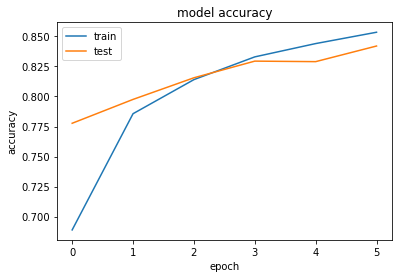

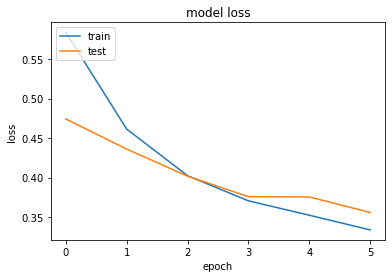

In [204]:

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [211]:
instance = X[9]
print(instance)

If you like original gut wrenching laughter you will like this movie If you are young or old then you will love this movie hell even my mom liked it Great Camp 


In [212]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.7111333]], dtype=float32)

In [213]:
y_pred = model.predict(instance)

if y_pred[0] < 0.5:
    value ='negative review'
else:
    value = 'positive review'
print("Predicted=%s,  %s " % ( y_pred[0], value ))

Predicted=[0.7111333],  positive review 


In [208]:
model.save('model-lstm-sentiment-movie.h5')

In [209]:
lstm_model= tf.keras.models.load_model('model-lstm-sentiment-movie.h5')

In [210]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 7s 22ms/step - loss: 0.3585 - acc: 0.8440
